In [37]:
from osgeo import gdal 
import numpy as np
import pandas as pd
import rasterio
from rasterio.windows import from_bounds
import matplotlib.pyplot as plt


from shapely.geometry import Point
from pyproj import CRS, Proj
import geopandas as gpd
from pyproj import CRS, Proj


In [38]:
# File paths
dem_path = "C:\\Users\\lukas\\OneDrive - Imperial College London\\0_Thesis\\0relevant_repositories\\hydronetworks\\data_laos\\Archive\\dem_con_asia.tif"
flow_path = "C:\\Users\\lukas\\OneDrive - Imperial College London\\0_Thesis\\0relevant_repositories\\hydronetworks\\data_laos\\Archive\\flow_asia.tif"
flow_acc_path = "C:\\Users\\lukas\\OneDrive - Imperial College London\\0_Thesis\\0relevant_repositories\\hydronetworks\\data_laos\\Archive\\as_acc_3s.tif"
xlsx_file = "C:\\Users\\lukas\\OneDrive - Imperial College London\\0_Thesis\\0relevant_repositories\\hydronetworks\\data_laos\\hydropower_list.xlsx"

In [39]:
original_df = pd.read_excel(xlsx_file)
original_df = original_df.dropna(subset=['head'])
original_df.iloc[:10]

,SNo,Status,Fuel Type,Latitude,Longitude,capacity,Expected Generation (GWh),total theoretical possible generation (local) GWh,COD,head
0,1,Existing,Reservoir,18.530336,102.547646,155.0,1025.0,1357.80000,1971.0,45.5
1,2,Existing,Run - Off,15.491752,106.278715,45.0,180.0,394.20000,1991.0,10.0
2,3,Existing,Reservoir,18.261088,104.562496,440.0,2691.0,0.43800,2013.0,27.0
3,4,Existing,Reservoir,15.059603,106.764106,152.0,450.0,17.52000,1999.0,79.0
4,5,Existing,Reservoir,18.437522,102.947408,60.0,215.0,525.60000,2000.0,45.5
5,6,Existing,Reservoir,18.349700,102.765261,40.0,150.0,350.40000,2009.0,17.0
6,7,Existing,Run - Off,15.403767,106.280347,76.0,309.0,665.76000,2009.0,12.0
7,8,Existing,Reservoir,18.793567,102.116356,100.0,435.0,876.00000,2010.0,73.0
8,9,Existing,Reservoir,17.997514,104.952542,1080.0,6000.0,659.41776,2010.0,39.0
9,10,Existing,Reservoir,18.751194,102.775597,615.0,2300.0,5000.00000,2012.0,181.0


# 1 Head Calculation

## 1.1 Calculation with minimum elevation and plant elevation

In [59]:
# Calculate head as the difference between max elevation and plant elevation
def calculate_head(dem, dem_transform, plant_lat, plant_lon):
    max_elevation = np.max(dem)
    row, col = ~dem_transform * (plant_lon, plant_lat)
    row = int(np.clip(row, 0, dem.shape[0] - 1))
    col = int(np.clip(col, 0, dem.shape[1] - 1))
    plant_elevation = dem[row, col]
    
    ### Test
    min_elevation = np.min(dem)
    temp = max_elevation - min_elevation
    # temp = max_elevation - plant_elevation
    
    return temp

# Extract area of interest around a point
def extract_area_of_interest(dem_path, lat, lon, buffer):
    minx, miny = lon - buffer, lat - buffer
    maxx, maxy = lon + buffer, lat + buffer
    with rasterio.open(dem_path) as dem_dataset:
        window = from_bounds(minx, miny, maxx, maxy, dem_dataset.transform)
        dem = dem_dataset.read(1, window=window)
        dem_transform = dem_dataset.transform
    return dem, dem_transform

# Update hydropower plant data with calculated heads
def update_hydropower_plant_data(df, dem_path, buffer):
    for index, row in df.iterrows():
        dem, dem_transform = extract_area_of_interest(dem_path, row['Latitude'], row['Longitude'], buffer)
        df.at[index, 'head_calculated'] = calculate_head(dem, dem_transform, row['Latitude'], row['Longitude'])
    df['head_difference'] = df['head'] - df['head_calculated']
    return df

# Find the optimal buffer size for minimizing combined metric
def optimize_buffer_size(df, dem_path, buffer_range):
    best_df = None
    best_metric = float('inf')
    best_buffer = None
    best_mae = None
    best_std = None
    
    for buffer in buffer_range:
        updated_df = update_hydropower_plant_data(df.copy(), dem_path, buffer)
        mean_absolute_difference = updated_df['head_difference'].abs().mean()
        std_difference = updated_df['head_difference'].std()
        combined_metric = mean_absolute_difference + std_difference
        
        if combined_metric < best_metric:
            best_metric = combined_metric
            best_df = updated_df
            best_buffer = buffer
            best_mae = mean_absolute_difference
            best_std = std_difference
    
    print(f"Optimal Buffer: {best_buffer}")
    print(f"Mean Absolute Error: {best_mae}")
    print(f"Standard Deviation: {best_std}")
    
    return best_df, best_buffer

# Optimize for each fuel type separately and combine results, considering only rows with a valid 'head' value
def optimize_for_fuel_types(xlsx_file, dem_path, buffer_range):
    df = pd.read_excel(xlsx_file)
    
    # Filter only rows where 'head' is not NaN
    df_with_head = df.dropna(subset=['head'])
    
    reservoir_df = df_with_head[df_with_head['Fuel Type'] == 'Reservoir'].copy()
    runoff_df = df_with_head[df_with_head['Fuel Type'] == 'Run - Off'].copy()
    
    print("\nOptimizing for Reservoir plants...")
    optimized_reservoir_df, reservoir_buffer = optimize_buffer_size(reservoir_df, dem_path, buffer_range)
    
    print("\nOptimizing for Run - Off plants...")
    optimized_runoff_df, runoff_buffer = optimize_buffer_size(runoff_df, dem_path, buffer_range)
    
    return optimized_reservoir_df, optimized_runoff_df, reservoir_buffer, runoff_buffer

# Function to fill missing head values using optimized buffer sizes
def fill_missing_head_values(df, dem_path, reservoir_buffer, runoff_buffer):
    # Filter rows where 'head' is NaN
    df_missing_head = df[df['head'].isna()].copy()
    
    for index, row in df_missing_head.iterrows():
        buffer = reservoir_buffer if row['Fuel Type'] == 'Reservoir' else runoff_buffer
        dem, dem_transform = extract_area_of_interest(dem_path, row['Latitude'], row['Longitude'], buffer)
        df.at[index, 'head'] = calculate_head(dem, dem_transform, row['Latitude'], row['Longitude'])
    
    return df

In [60]:
# Example usage
buffer_range = np.linspace(0.00025, 0.005, 101)
optimized_reservoir_df, optimized_runoff_df, reservoir_buffer, runoff_buffer = optimize_for_fuel_types(xlsx_file, dem_path, buffer_range)
combined_df = pd.concat([optimized_reservoir_df, optimized_runoff_df])


Optimizing for Reservoir plants...
Optimal Buffer: 0.0019125
Mean Absolute Error: 31.0140625
Standard Deviation: 38.83566983472922

Optimizing for Run - Off plants...
Optimal Buffer: 0.001105
Mean Absolute Error: 51.2
Standard Deviation: 86.12798004927564


In [61]:
method_B_runoff = optimized_runoff_df.copy()
optimized_runoff_df.iloc[:10]

,SNo,Status,Fuel Type,Latitude,Longitude,capacity,Expected Generation (GWh),total theoretical possible generation (local) GWh,COD,head,head_calculated,head_difference
1,2,Existing,Run - Off,15.491752,106.278715,45.00,180.00,394.200,1991.0,10.0,5.0,5.0
6,7,Existing,Run - Off,15.403767,106.280347,76.00,309.00,665.760,2009.0,12.0,13.0,-1.0
11,12,Existing,Run - Off,18.798566,102.426838,6.00,25.00,52.560,2012.0,21.0,11.0,10.0
14,16,Existing,Run - Off,15.134441,106.678223,14.80,101.00,129.648,2013.0,75.0,26.0,49.0
17,19,Existing,Run - Off,19.211544,102.329586,14.00,49.60,122.640,2014.0,7.0,80.0,-73.0
31,36,Existing,Run - Off,19.212686,103.374882,14.55,33.07,127.458,2017.0,356.0,53.0,303.0
33,38,Existing,Run - Off,20.181548,101.923022,14.50,62.59,127.020,2017.0,47.0,23.0,24.0
40,46,Existing,Run - Off,15.575719,106.222823,15.00,60.00,131.400,2018.0,64.0,25.0,39.0
43,50,Existing,Run - Off,18.619253,102.387400,64.00,265.00,566.772,2019.0,39.5,54.0,-14.5
45,52,Existing,Run - Off,18.648161,103.571726,18.00,105.00,157.680,2019.0,43.0,17.0,26.0


### Boxplot, percentage change

Average Percentage Change for Reservoir: 43.11%
Average Percentage Change for Run-Off: 141.18%


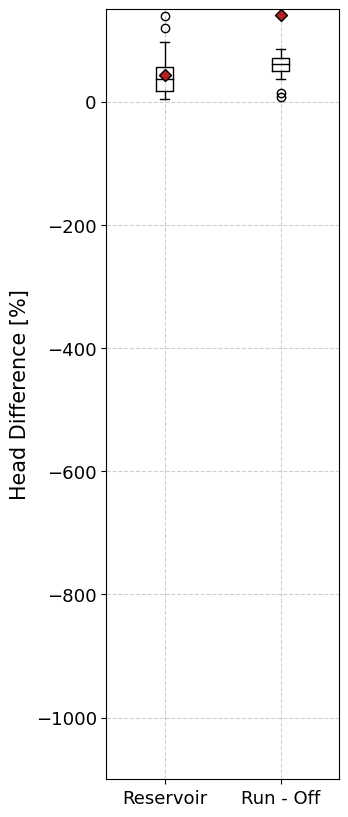

In [64]:
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
medianprops = dict(linestyle='-', color='black')

def plot_head_difference_boxplots(combined_df, ylim=None):
    # Calculate percentage difference for Reservoir and Run-Off
    combined_df['percent_difference'] = combined_df['head_difference'] / combined_df['head'] * 100

    reservoir_percent_diff = (combined_df[combined_df['Fuel Type'] == 'Reservoir']['percent_difference'].dropna()).abs()
    runoff_percent_diff = (combined_df[combined_df['Fuel Type'] == 'Run - Off']['percent_difference'].dropna()).abs()

    # Calculate and print the average percentage change
    reservoir_mean = reservoir_percent_diff.mean()
    runoff_mean = runoff_percent_diff.mean()
    
    print(f"Average Percentage Change for Reservoir: {reservoir_mean:.2f}%")
    print(f"Average Percentage Change for Run-Off: {runoff_mean:.2f}%")

    if not reservoir_percent_diff.empty and not runoff_percent_diff.empty:
        plt.figure(figsize=(3, 10))
        plt.boxplot([reservoir_percent_diff, runoff_percent_diff], 
                    labels=['Reservoir', 'Run - Off'], 
                    medianprops=medianprops,
                    showmeans=True, meanprops=meanpointprops)
        plt.ylabel('Head Difference [%]', fontsize=15)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        
        # Apply the y-axis limit if provided
        if ylim is not None:
            plt.ylim(ylim)
        
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
    else:
        print("No data available for plotting.")

# Example usage
ylim = [-1100,150] # [-250, 200]
plot_head_difference_boxplots(combined_df, ylim)


### Boxplot

In [ ]:
# Plot a boxplot comparing head differences for Reservoir and Run - Off
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
medianprops = dict(linestyle='-', color='black')
def plot_head_difference_boxplots(combined_df,ylim):
    reservoir_head_diff = combined_df[combined_df['Fuel Type'] == 'Reservoir']['head_difference'].dropna()
    runoff_head_diff = combined_df[combined_df['Fuel Type'] == 'Run - Off']['head_difference'].dropna()

    if not reservoir_head_diff.empty and not runoff_head_diff.empty:
        plt.figure(figsize=(3, 10))
        plt.boxplot([reservoir_head_diff, runoff_head_diff], 
                    labels=['Reservoir', 'Run - Off'], 
                    # patch_artist=True, 
                    medianprops=medianprops,
                    showmeans=True, meanprops=meanpointprops)
        # plt.title('Boxplot of Head Difference for Reservoir and Run - Off Plants')
        plt.ylabel('Head Difference [metres]', fontsize=15)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        
        # Apply the y-axis limit if provided
        if ylim is not None:
            plt.ylim(ylim)
        
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
    else:
        print("No data available for plotting.")
        
        # Combine the optimized results

ylim = [-150, 310]
# Plot the boxplots
plot_head_difference_boxplots(combined_df,ylim)

### Boxplot - absolute values

In [ ]:
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
medianprops = dict(linestyle='-', color='black')

def plot_absolute_difference_boxplots(combined_df,ylim):
    # Calculate the absolute difference for both Reservoir and Run-Off
    reservoir_abs_diff = combined_df[combined_df['Fuel Type'] == 'Reservoir']['head_difference'].abs().dropna()
    runoff_abs_diff = combined_df[combined_df['Fuel Type'] == 'Run - Off']['head_difference'].abs().dropna()

    # Check if there's data to plot
    if not reservoir_abs_diff.empty and not runoff_abs_diff.empty:
        plt.figure(figsize=(3, 10))
        plt.boxplot(
            [reservoir_abs_diff, runoff_abs_diff], 
            labels=['Reservoir', 'Run - Off'], 
            # patch_artist=True, 
            medianprops=medianprops,
            showmeans=True, meanprops=meanpointprops
        )
        # plt.title('Boxplot of Absolute Head Difference for Reservoir and Run - Off Plants')
        plt.ylabel('Absolute Head Difference [metres]', fontsize=15)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        
        # Apply the y-axis limit if provided
        if ylim is not None:
            plt.ylim(ylim)
        
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
    else:
        print("No data available for plotting.")
        
ylim = [-10, 320]
plot_absolute_difference_boxplots(combined_df,ylim)


## 1.2 Calculation based on hydronetwork

In [53]:
wgs84 = CRS("EPSG:4326")
merc = CRS("EPSG:3395")
merc_pro = Proj("EPSG:3395")

class LocalHydroNetwork:
    def __init__(self, dem_path, flow_path, flow_acc_path):
        self.dem = rasterio.open(dem_path)
        self.flow = rasterio.open(flow_path)
        self.flow_acc = rasterio.open(flow_acc_path)

    def create_local_network(self, point, buffer=0.005):
        minx, miny = point.x - buffer, point.y - buffer
        maxx, maxy = point.x + buffer, point.y + buffer

        window = rasterio.windows.from_bounds(minx, miny, maxx, maxy, self.dem.transform)
        dem_local = self.dem.read(1, window=window)
        flow_local = self.flow.read(1, window=window)
        flow_acc_local = self.flow_acc.read(1, window=window)

        transform = rasterio.windows.transform(window, self.dem.transform)

        nodes, arcs = self._extract_nodes_arcs(dem_local, flow_local, flow_acc_local, transform)
        return nodes, arcs

    def _extract_nodes_arcs(self, dem_local, flow_local, flow_acc_local, transform):
        nodes = []
        arcs = []
        height, width = dem_local.shape
        node_index_map = {}

        for i in range(height):
            for j in range(width):
                x, y = transform * (j, i)
                elevation = dem_local[i, j]
                flow_dir = flow_local[i, j]
                flow_acc = flow_acc_local[i, j]

                current_node = (i, j)
                if current_node not in node_index_map:
                    node_id = len(nodes)
                    node = {
                        'id': node_id,
                        'x': x,
                        'y': y,
                        'elevation': elevation,
                        'flow_acc': flow_acc,
                        'arcs': []
                    }
                    nodes.append(node)
                    node_index_map[current_node] = node_id
                else:
                    node_id = node_index_map[current_node]

                if flow_dir > 0:
                    next_i, next_j = self._flow_direction_to_indices(i, j, flow_dir)
                    if 0 <= next_i < height and 0 <= next_j < width:
                        next_node = (next_i, next_j)
                        if next_node not in node_index_map:
                            next_node_id = len(nodes)
                            next_x, next_y = transform * (next_j, next_i)
                            next_elevation = dem_local[next_i, next_j]
                            next_flow_acc = flow_acc_local[next_i, next_j]

                            next_node_data = {
                                'id': next_node_id,
                                'x': next_x,
                                'y': next_y,
                                'elevation': next_elevation,
                                'flow_acc': next_flow_acc,
                                'arcs': []
                            }
                            nodes.append(next_node_data)
                            node_index_map[next_node] = next_node_id
                        else:
                            next_node_id = node_index_map[next_node]

                        arc = {
                            'start_node': node_id,
                            'end_node': next_node_id,
                            'length': np.hypot(next_i - i, next_j - j)
                        }
                        nodes[node_id]['arcs'].append(arc)
                        arcs.append(arc)

        return nodes, arcs

    def _flow_direction_to_indices(self, i, j, direction):
        if direction == 1:  # East
            return i, j + 1
        elif direction == 2:  # Southeast
            return i + 1, j + 1
        elif direction == 4:  # South
            return i + 1, j
        elif direction == 8:  # Southwest
            return i + 1, j - 1
        elif direction == 16:  # West
            return i, j - 1
        elif direction == 32:  # Northwest
            return i - 1, j - 1
        elif direction == 64:  # North
            return i - 1, j
        elif direction == 128:  # Northeast
            return i - 1, j + 1
        else:
            return i, j  # No direction

    def calculate_head(self, nodes, arcs):
        max_head = 0
        for arc in arcs:
            start_node = nodes[arc['start_node']]
            end_node = nodes[arc['end_node']]
            head = start_node['elevation'] - end_node['elevation']
            if head > max_head:
                max_head = head
        return max_head

    def process_hydropower_plants(self, df, buffer):
        df['head_calculated'] = pd.NA
        for index, row in df.iterrows():
            point = Point(row['Longitude'], row['Latitude'])
            nodes, arcs = self.create_local_network(point, buffer)
            head = self.calculate_head(nodes, arcs)
            df.at[index, 'head_calculated'] = head
        df['head_difference'] = df['head'] - df['head_calculated']
        return df

    def optimize_buffer(self, df, buffer_range):
        best_mae = float('inf')
        best_std = float('inf')
        best_buffer = None
        best_df = None
        
        for buffer in buffer_range:
            df_processed = self.process_hydropower_plants(df.copy(), buffer)
            mae = df_processed['head_difference'].abs().mean()
            std = df_processed['head_difference'].std()
            # if mae< best_mae:
            if mae + std < best_mae + best_std:
                best_mae = mae
                best_std = std
                best_buffer = buffer
                best_df = df_processed
        
        print(f"Optimal Buffer: {best_buffer}")
        print(f"Mean Absolute Error: {best_mae}")
        print(f"Standard Deviation: {best_std}")
        
        return best_df, best_buffer, best_mae, best_std

    def optimize_for_fuel_types(self, df, buffer_range):
        reservoir_df = df[df['Fuel Type'] == 'Reservoir'].copy()
        runoff_df = df[df['Fuel Type'] == 'Run - Off'].copy()

        print("\nOptimizing for Reservoir plants...")
        optimized_reservoir_df, optimal_reservoir_buffer, reservoir_mae, reservoir_std = self.optimize_buffer(reservoir_df, buffer_range)
        
        print("\nOptimizing for Run - Off plants...")
        optimized_runoff_df, optimal_runoff_buffer, runoff_mae, runoff_std = self.optimize_buffer(runoff_df, buffer_range)

        return {
            'reservoir': {
                'df': optimized_reservoir_df, 
                'buffer': optimal_reservoir_buffer, 
                'mae': reservoir_mae, 
                'std': reservoir_std
            },
            'runoff': {
                'df': optimized_runoff_df, 
                'buffer': optimal_runoff_buffer, 
                'mae': runoff_mae, 
                'std': runoff_std
            }
        }

In [55]:
# Example usage
buffer_range = np.linspace(0.0005, 0.01, 21)
hydro_network = LocalHydroNetwork(dem_path, flow_path, flow_acc_path)

# Load your hydropower plant data
df = pd.read_excel(xlsx_file)
df = df.dropna(subset=['head'])

# Optimize buffer separately for Reservoir and Run-Off
results = hydro_network.optimize_for_fuel_types(df, buffer_range)

# Access the optimized DataFrames
optimized_reservoir_df = results['reservoir']['df']
optimized_runoff_df = results['runoff']['df']

# # Print results for Reservoir
# print("\nReservoir - Optimal Buffer: ", results['reservoir']['buffer'])
# print("Mean Absolute Error: ", results['reservoir']['mae'])
# print("Standard Deviation: ", results['reservoir']['std'])

# # Print results for Run-Off
# print("\nRun - Off - Optimal Buffer: ", results['runoff']['buffer'])
# print("Mean Absolute Error: ", results['runoff']['mae'])
# print("Standard Deviation: ", results['runoff']['std'])


Optimizing for Reservoir plants...
Optimal Buffer: 0.003825
Mean Absolute Error: 26.9890625
Standard Deviation: 30.49839659818994

Optimizing for Run - Off plants...
Optimal Buffer: 0.00335
Mean Absolute Error: 45.85
Standard Deviation: 84.40090732862258


In [56]:
method_B_runoff.iloc[:10]

,SNo,Status,Fuel Type,Latitude,Longitude,capacity,Expected Generation (GWh),total theoretical possible generation (local) GWh,COD,head,head_calculated,head_difference
1,2,Existing,Run - Off,15.491752,106.278715,45.00,180.00,394.200,1991.0,10.0,5.0,5.0
6,7,Existing,Run - Off,15.403767,106.280347,76.00,309.00,665.760,2009.0,12.0,13.0,-1.0
11,12,Existing,Run - Off,18.798566,102.426838,6.00,25.00,52.560,2012.0,21.0,11.0,10.0
14,16,Existing,Run - Off,15.134441,106.678223,14.80,101.00,129.648,2013.0,75.0,26.0,49.0
17,19,Existing,Run - Off,19.211544,102.329586,14.00,49.60,122.640,2014.0,7.0,80.0,-73.0
31,36,Existing,Run - Off,19.212686,103.374882,14.55,33.07,127.458,2017.0,356.0,53.0,303.0
33,38,Existing,Run - Off,20.181548,101.923022,14.50,62.59,127.020,2017.0,47.0,23.0,24.0
40,46,Existing,Run - Off,15.575719,106.222823,15.00,60.00,131.400,2018.0,64.0,25.0,39.0
43,50,Existing,Run - Off,18.619253,102.387400,64.00,265.00,566.772,2019.0,39.5,54.0,-14.5
45,52,Existing,Run - Off,18.648161,103.571726,18.00,105.00,157.680,2019.0,43.0,17.0,26.0


In [57]:
optimized_runoff_df.iloc[:10]

,SNo,Status,Fuel Type,Latitude,Longitude,capacity,Expected Generation (GWh),total theoretical possible generation (local) GWh,COD,head,head_calculated,head_difference
1,2,Existing,Run - Off,15.491752,106.278715,45.00,180.00,394.200,1991.0,10.0,32,-22.0
6,7,Existing,Run - Off,15.403767,106.280347,76.00,309.00,665.760,2009.0,12.0,18,-6.0
11,12,Existing,Run - Off,18.798566,102.426838,6.00,25.00,52.560,2012.0,21.0,22,-1.0
14,16,Existing,Run - Off,15.134441,106.678223,14.80,101.00,129.648,2013.0,75.0,38,37.0
17,19,Existing,Run - Off,19.211544,102.329586,14.00,49.60,122.640,2014.0,7.0,82,-75.0
31,36,Existing,Run - Off,19.212686,103.374882,14.55,33.07,127.458,2017.0,356.0,60,296.0
33,38,Existing,Run - Off,20.181548,101.923022,14.50,62.59,127.020,2017.0,47.0,55,-8.0
40,46,Existing,Run - Off,15.575719,106.222823,15.00,60.00,131.400,2018.0,64.0,18,46.0
43,50,Existing,Run - Off,18.619253,102.387400,64.00,265.00,566.772,2019.0,39.5,56,-16.5
45,52,Existing,Run - Off,18.648161,103.571726,18.00,105.00,157.680,2019.0,43.0,15,28.0


### Boxplot - % change

Average Percentage Change for Reservoir: 35.45%
Average Percentage Change for Run-Off: 142.94%


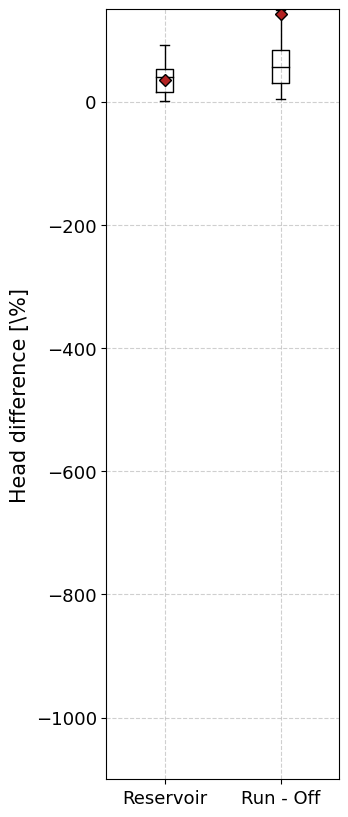

In [58]:
def plot_relative_head_difference_boxplots(reservoir_df, runoff_df, ylim):
    reservoir_df['percent_difference'] = reservoir_df['head_difference'] / reservoir_df['head'] * 100
    runoff_df['percent_difference'] = runoff_df['head_difference'] / runoff_df['head'] * 100
    
    reservoir_head_diff_per = reservoir_df['percent_difference'].abs().dropna()
    runoff_head_diff_per = runoff_df['percent_difference'].abs().dropna()
    # reservoir_head_diff_per = reservoir_df['percent_difference'].dropna()
    # runoff_head_diff_per = runoff_df['percent_difference'].dropna()
    
    # Calculate and print the average percentage change
    reservoir_mean = reservoir_head_diff_per.mean()
    runoff_mean = runoff_head_diff_per.mean()
    
    print(f"Average Percentage Change for Reservoir: {reservoir_mean:.2f}%")
    print(f"Average Percentage Change for Run-Off: {runoff_mean:.2f}%")
    
    
    if not reservoir_head_diff_per.empty and not runoff_head_diff_per.empty:
        plt.figure(figsize=(3, 10))
        plt.boxplot([reservoir_head_diff_per, runoff_head_diff_per], 
                    labels=['Reservoir', 'Run - Off'], 
                    # patch_artist=True, 
                    medianprops=medianprops,
                    showmeans=True, meanprops=meanpointprops)
        plt.ylabel('Head difference [\%]', fontsize=15)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        if ylim is not None:
            plt.ylim(ylim)
        
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
        
        
    else:
        print("No data available for plotting.")
        
# Plot the boxplots
ylim = [-1100,150]
plot_relative_head_difference_boxplots(optimized_reservoir_df, optimized_runoff_df,ylim)

In [195]:
optimized_runoff_df.dropna(subset=['head'])

,SNo,Status,Fuel Type,Latitude,Longitude,capacity,Expected Generation (GWh),total theoretical possible generation (local) GWh,COD,head,head_calculated,head_difference
1,2,Existing,Run - Off,15.491752,106.278715,45.00,180.00,394.200,1991.0,10.0,32,-22.0
6,7,Existing,Run - Off,15.403767,106.280347,76.00,309.00,665.760,2009.0,12.0,18,-6.0
11,12,Existing,Run - Off,18.798566,102.426838,6.00,25.00,52.560,2012.0,21.0,22,-1.0
14,16,Existing,Run - Off,15.134441,106.678223,14.80,101.00,129.648,2013.0,75.0,38,37.0
17,19,Existing,Run - Off,19.211544,102.329586,14.00,49.60,122.640,2014.0,7.0,82,-75.0
31,36,Existing,Run - Off,19.212686,103.374882,14.55,33.07,127.458,2017.0,356.0,60,296.0
33,38,Existing,Run - Off,20.181548,101.923022,14.50,62.59,127.020,2017.0,47.0,55,-8.0
40,46,Existing,Run - Off,15.575719,106.222823,15.00,60.00,131.400,2018.0,64.0,18,46.0
43,50,Existing,Run - Off,18.619253,102.387400,64.00,265.00,566.772,2019.0,39.5,56,-16.5
45,52,Existing,Run - Off,18.648161,103.571726,18.00,105.00,157.680,2019.0,43.0,15,28.0


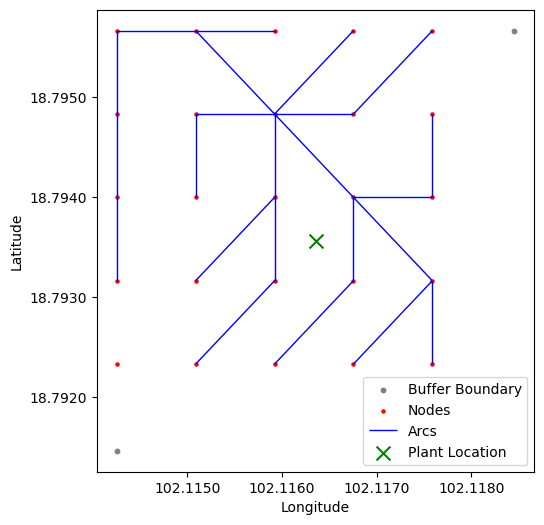

In [310]:
import numpy as np
import pandas as pd
import rasterio
from shapely.geometry import Point, LineString
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter

class LocalHydroNetwork:
    def __init__(self, dem_path, flow_path, flow_acc_path):
        self.dem = rasterio.open(dem_path)
        self.flow = rasterio.open(flow_path)
        self.flow_acc = rasterio.open(flow_acc_path)

    def create_local_network(self, point, buffer=0.005):
        # Calculate bounding box around the point using the buffer
        minx, miny = point.x - buffer, point.y - buffer
        maxx, maxy = point.x + buffer, point.y + buffer

        # Ensure the point (plant location) is centered by manually adjusting the window
        window = rasterio.windows.from_bounds(minx, miny, maxx, maxy, self.dem.transform)
        dem_local = self.dem.read(1, window=window)
        flow_local = self.flow.read(1, window=window)
        flow_acc_local = self.flow_acc.read(1, window=window)

        transform = rasterio.windows.transform(window, self.dem.transform)

        nodes, arcs = self._extract_nodes_arcs(dem_local, flow_local, flow_acc_local, transform)
        return nodes, arcs

    def _extract_nodes_arcs(self, dem_local, flow_local, flow_acc_local, transform):
        nodes = []
        arcs = []
        height, width = dem_local.shape
        node_index_map = {}

        for i in range(height):
            for j in range(width):
                x, y = transform * (j, i)
                elevation = dem_local[i, j]
                flow_dir = flow_local[i, j]
                flow_acc = flow_acc_local[i, j]

                current_node = (i, j)
                if current_node not in node_index_map:
                    node_id = len(nodes)
                    node = {
                        'id': node_id,
                        'x': x,
                        'y': y,
                        'elevation': elevation,
                        'flow_acc': flow_acc,
                        'arcs': []
                    }
                    nodes.append(node)
                    node_index_map[current_node] = node_id
                else:
                    node_id = node_index_map[current_node]

                if flow_dir > 0:
                    next_i, next_j = self._flow_direction_to_indices(i, j, flow_dir)
                    if 0 <= next_i < height and 0 <= next_j < width:
                        next_node = (next_i, next_j)
                        if next_node not in node_index_map:
                            next_node_id = len(nodes)
                            next_x, next_y = transform * (next_j, next_i)
                            next_elevation = dem_local[next_i, next_j]
                            next_flow_acc = flow_acc_local[next_i, next_j]

                            next_node_data = {
                                'id': next_node_id,
                                'x': next_x,
                                'y': next_y,
                                'elevation': next_elevation,
                                'flow_acc': next_flow_acc,
                                'arcs': []
                            }
                            nodes.append(next_node_data)
                            node_index_map[next_node] = next_node_id
                        else:
                            next_node_id = node_index_map[next_node]

                        arc = {
                            'start_node': node_id,
                            'end_node': next_node_id,
                            'length': np.hypot(next_i - i, next_j - j)
                        }
                        nodes[node_id]['arcs'].append(arc)
                        arcs.append(arc)

        return nodes, arcs

    def _flow_direction_to_indices(self, i, j, direction):
        if direction == 1:  # East
            return i, j + 1
        elif direction == 2:  # Southeast
            return i + 1, j + 1
        elif direction == 4:  # South
            return i + 1, j
        elif direction == 8:  # Southwest
            return i + 1, j - 1
        elif direction == 16:  # West
            return i, j - 1
        elif direction == 32:  # Northwest
            return i - 1, j - 1
        elif direction == 64:  # North
            return i - 1, j
        elif direction == 128:  # Northeast
            return i - 1, j + 1
        else:
            return i, j  # No direction

def format_lon_lat(value, pos):
    """Formats the longitude and latitude values for display."""
    return f'{value:.4f}'  # Adjust the precision as needed

def visualize_network(point, buffer, nodes, arcs):
    # Create the buffer boundary
    minx, miny = point.x - buffer, point.y - buffer
    maxx, maxy = point.x + buffer, point.y + buffer

    buffer_boundary = gpd.GeoSeries([Point(minx, miny), Point(maxx, maxy)], crs="EPSG:4326")

    # Create GeoDataFrames for nodes and arcs
    node_geometries = [Point(node['x'], node['y']) for node in nodes]
    nodes_gdf = gpd.GeoDataFrame(nodes, geometry=node_geometries, crs="EPSG:4326")

    arc_geometries = []
    for arc in arcs:
        start_node = nodes[arc['start_node']]
        end_node = nodes[arc['end_node']]
        arc_geometries.append(LineString([(start_node['x'], start_node['y']), (end_node['x'], end_node['y'])]))
    arcs_gdf = gpd.GeoDataFrame(arcs, geometry=arc_geometries, crs="EPSG:4326")

    # Plot the buffer boundary, nodes, and arcs
    fig, ax = plt.subplots(figsize=(6, 6))
    buffer_boundary.plot(ax=ax, marker='o', color='gray', markersize=10, label='Buffer Boundary')
    nodes_gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='Nodes')
    arcs_gdf.plot(ax=ax, color='blue', linewidth=1, label='Arcs')

    # Plotting the plant location
    plant_location = gpd.GeoSeries([point], crs="EPSG:4326")
    plant_location.plot(ax=ax, marker='x', color='green', markersize=100, label='Plant Location')

    # Format the longitude and latitude display
    ax.xaxis.set_major_formatter(FuncFormatter(format_lon_lat))
    ax.yaxis.set_major_formatter(FuncFormatter(format_lon_lat))
    
    ax.xaxis.set_major_locator(mticker.MaxNLocator(5))  # Adjust the number of ticks
    ax.yaxis.set_major_locator(mticker.MaxNLocator(5))  # Adjust the number of ticks

    # plt.title('Buffer Zone and Hydrological Network')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    # plt.grid(True)
    plt.show()

# Example usage:
plant = 7 # 7
buffer = 0.0021  # Adjust buffer as needed
point = Point(df.iloc[plant]['Longitude'], df.iloc[plant]['Latitude'])  # Assuming the first plant in your DataFrame

# Create the local hydrological network around the first plant
nodes, arcs = hydro_network.create_local_network(point, buffer)

# Visualize the buffer and network
visualize_network(point, buffer, nodes, arcs)


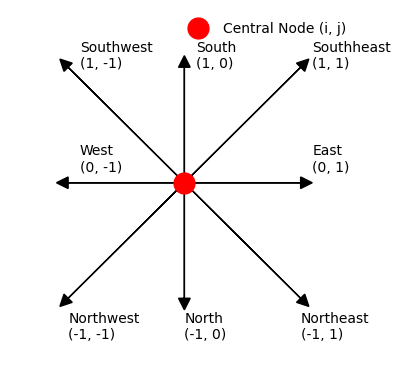

In [311]:
import matplotlib.pyplot as plt
import numpy as np

# Define the directions with corresponding flow direction codes
D8_DIRECTIONS = {
    1: ('East', (0, 1)),
    2: ('Southheast', (1, 1)),
    4: ('South', (1, 0)),
    8: ('Southwest', (1, -1)),
    16: ('West', (0, -1)),
    32: ('Northwest', (-1, -1)),
    64: ('North', (-1, 0)),
    128: ('Northeast', (-1, 1))
}

def plot_d8_method():
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)

    # Plot the central node
    central_node = (0, 0)
    ax.plot(central_node[1], central_node[0], 'ro', markersize=15, label="Central Node (i, j)")
    ax.text(central_node[1] + 0.1, central_node[0], '', fontsize=12, ha='left')

    # Plot the neighboring nodes
    for code, (direction, (di, dj)) in D8_DIRECTIONS.items():
        neighbor_node = (central_node[0] + di, central_node[1] + dj)
        ax.plot(neighbor_node[1], neighbor_node[0], 'bo', markersize=0)
        ax.arrow(central_node[1], central_node[0], dj, di, head_width=0.1, head_length=0.1, fc='black', ec='black')
        
        # Format the direction annotations
        di_text = f'{di}' if di != 0 else '0'
        dj_text = f'{dj}' if dj != 0 else '0'
        
        # Adjusting text position
        if di == 0:
            ax.text(neighbor_node[1] + 0.1, neighbor_node[0] + 0.1, f'{direction}\n({di_text}, {dj_text})', fontsize=10, ha='left')
        elif di == -1:
            ax.text(neighbor_node[1], neighbor_node[0] - 0.35, f'{direction}\n({di_text}, {dj_text})', fontsize=10, ha='left')
        else:
            ax.text(neighbor_node[1] + 0.1, neighbor_node[0], f'{direction}\n({di_text}, {dj_text})', fontsize=10, ha='left')

    # Remove the axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Remove the outer box (spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.legend(frameon=False)
    plt.show()

# Call the function to plot
plot_d8_method()


### Boxplot

In [ ]:
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
medianprops = dict(linestyle='-', color='black')
# Plotting function for boxplot
def plot_head_difference_boxplots(reservoir_df, runoff_df):
    reservoir_head_diff = reservoir_df['head_difference'].dropna()
    runoff_head_diff = runoff_df['head_difference'].dropna()

    if not reservoir_head_diff.empty and not runoff_head_diff.empty:
        plt.figure(figsize=(3, 10))
        plt.boxplot([reservoir_head_diff, runoff_head_diff], 
                    labels=['Reservoir', 'Run - Off'], 
                    # patch_artist=True, 
                    medianprops=medianprops,
                    showmeans=True, meanprops=meanpointprops)
        plt.ylabel('Head Difference [metres]', fontsize=15)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
    else:
        print("No data available for plotting.")
        
# Plot the boxplots
plot_head_difference_boxplots(optimized_reservoir_df, optimized_runoff_df)

### Boxplot - absolute values

In [ ]:
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
medianprops = dict(linestyle='-', color='black')
# Plotting function for boxplot
def plot_head_difference_boxplots(reservoir_df, runoff_df):
    reservoir_head_diff = reservoir_df['head_difference'].abs().dropna()
    runoff_head_diff = runoff_df['head_difference'].abs().dropna()

    if not reservoir_head_diff.empty and not runoff_head_diff.empty:
        plt.figure(figsize=(3, 10))
        plt.boxplot([reservoir_head_diff, runoff_head_diff], 
                    labels=['Reservoir', 'Run - Off'], 
                    # patch_artist=True, 
                    medianprops=medianprops,
                    showmeans=True, meanprops=meanpointprops)
        plt.ylabel('Head Difference [metres]', fontsize=15)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
    else:
        print("No data available for plotting.")
        
# Plot the boxplots
plot_head_difference_boxplots(optimized_reservoir_df, optimized_runoff_df)

## 2 Relative boxplots

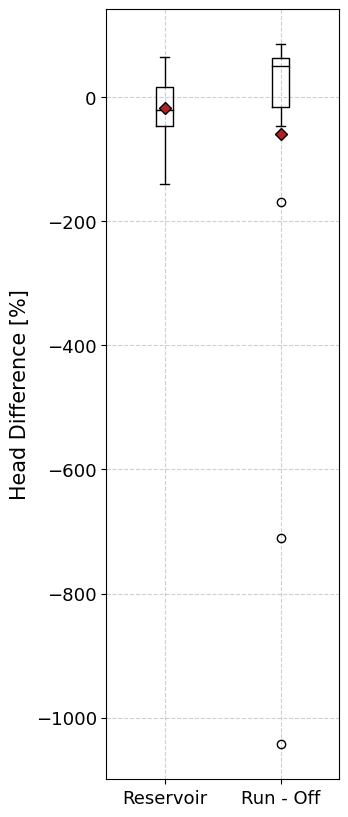

In [184]:
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
medianprops = dict(linestyle='-', color='black')

def plot_head_difference_boxplots(combined_df, ylim=None):
    # Calculate percentage difference for Reservoir and Run-Off
    combined_df['percent_difference'] = combined_df['head_difference'] / combined_df['head'] * 100

    reservoir_percent_diff = combined_df[combined_df['Fuel Type'] == 'Reservoir']['percent_difference'].dropna()
    runoff_percent_diff = combined_df[combined_df['Fuel Type'] == 'Run - Off']['percent_difference'].dropna()

    if not reservoir_percent_diff.empty and not runoff_percent_diff.empty:
        plt.figure(figsize=(3, 10))
        plt.boxplot([reservoir_percent_diff, runoff_percent_diff], 
                    labels=['Reservoir', 'Run - Off'], 
                    medianprops=medianprops,
                    showmeans=True, meanprops=meanpointprops)
        plt.ylabel('Head Difference [%]', fontsize=15)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        
        # Apply the y-axis limit if provided
        if ylim is not None:
            plt.ylim(ylim)
        
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
    else:
        print("No data available for plotting.")

# Example usage
ylim = None # [-250, 200]
plot_head_difference_boxplots(combined_df, ylim)


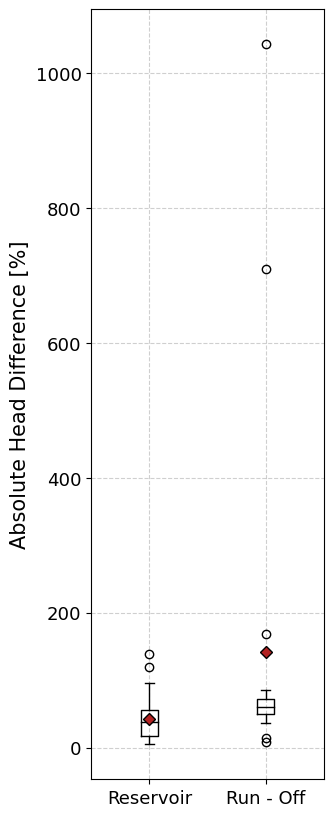

In [185]:
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
medianprops = dict(linestyle='-', color='black')

def plot_absolute_difference_boxplots(combined_df, ylim=None):
    # Calculate the absolute percentage difference for both Reservoir and Run-Off
    combined_df['percent_abs_difference'] = combined_df['head_difference'].abs() / combined_df['head'] * 100

    reservoir_abs_percent_diff = combined_df[combined_df['Fuel Type'] == 'Reservoir']['percent_abs_difference'].dropna()
    runoff_abs_percent_diff = combined_df[combined_df['Fuel Type'] == 'Run - Off']['percent_abs_difference'].dropna()

    if not reservoir_abs_percent_diff.empty and not runoff_abs_percent_diff.empty:
        plt.figure(figsize=(3, 10))
        plt.boxplot(
            [reservoir_abs_percent_diff, runoff_abs_percent_diff], 
            labels=['Reservoir', 'Run - Off'], 
            medianprops=medianprops,
            showmeans=True, meanprops=meanpointprops
        )
        plt.ylabel('Absolute Head Difference [%]', fontsize=15)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        
        # Apply the y-axis limit if provided
        if ylim is not None:
            plt.ylim(ylim)
        
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
    else:
        print("No data available for plotting.")

# Example usage
ylim = None #[-10, 320]
plot_absolute_difference_boxplots(combined_df, ylim)


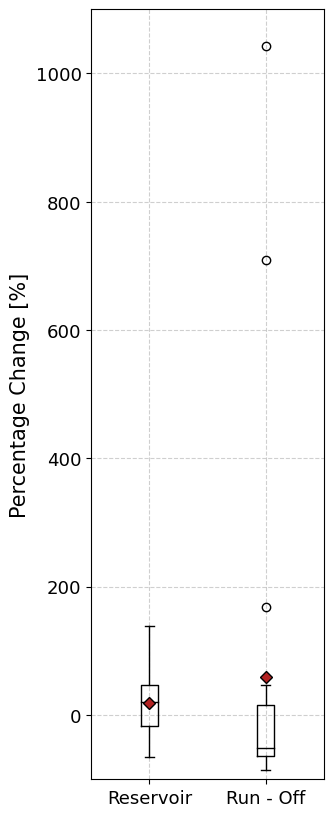

In [180]:
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
medianprops = dict(linestyle='-', color='black')

def plot_percentage_change_boxplots(combined_df, ylim=None):
    # Calculate percentage change for Reservoir and Run-Off
    combined_df['percent_change'] = ((combined_df['head_calculated'] - combined_df['head']) / combined_df['head']) * 100

    reservoir_percent_change = combined_df[combined_df['Fuel Type'] == 'Reservoir']['percent_change'].dropna()
    runoff_percent_change = combined_df[combined_df['Fuel Type'] == 'Run - Off']['percent_change'].dropna()

    if not reservoir_percent_change.empty and not runoff_percent_change.empty:
        plt.figure(figsize=(3, 10))
        plt.boxplot([reservoir_percent_change, runoff_percent_change], 
                    labels=['Reservoir', 'Run - Off'], 
                    medianprops=medianprops,
                    showmeans=True, meanprops=meanpointprops)
        plt.ylabel('Percentage Change [%]', fontsize=15)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        
        # Apply the y-axis limit if provided
        if ylim is not None:
            plt.ylim(ylim)
        
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
    else:
        print("No data available for plotting.")

# Example usage
# ylim = [-100, 1100]  # Adjust the ylim as necessary for your data
plot_percentage_change_boxplots(combined_df, ylim)


# 3 Enter calculated values in excel and export

In [ ]:

# Load the original DataFrame
original_df = pd.read_excel(xlsx_file)

# Fill the missing head values
filled_df = fill_missing_head_values(original_df, dem_path, reservoir_buffer, runoff_buffer)

# Save the updated DataFrame to a new Excel file
filled_df.to_excel("updated_hydropower_plants_with_filled_heads.xlsx", index=False)


### TEST


Optimizing for Reservoir plants...
Optimal Buffer: 0.003385
Mean Absolute Error: 26.0828125
Standard Deviation: 29.085272945574165

Optimizing for Run - Off plants...
Optimal Buffer: 0.003195
Mean Absolute Error: 45.85
Standard Deviation: 84.40090732862258


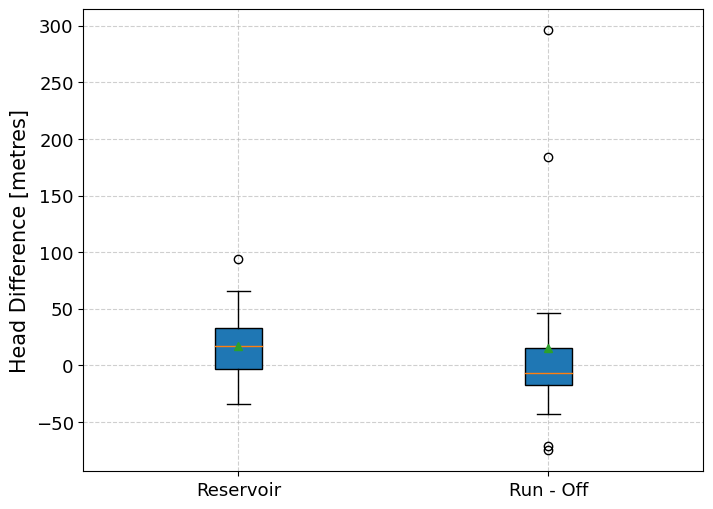

Missing head values have been filled and saved to 'updated_hydropower_plants_with_filled_heads.xlsx'.

Reservoir - Optimal Buffer:  0.003385
Mean Absolute Error:  26.0828125
Standard Deviation:  29.085272945574165

Run - Off - Optimal Buffer:  0.003195
Mean Absolute Error:  45.85
Standard Deviation:  84.40090732862258


In [149]:
import numpy as np
import pandas as pd
import rasterio
from shapely.geometry import Point
from pyproj import CRS, Proj
import geopandas as gpd
import matplotlib.pyplot as plt

wgs84 = CRS("EPSG:4326")
merc = CRS("EPSG:3395")
merc_pro = Proj("EPSG:3395")

class LocalHydroNetwork:
    def __init__(self, dem_path, flow_path, flow_acc_path):
        self.dem = rasterio.open(dem_path)
        self.flow = rasterio.open(flow_path)
        self.flow_acc = rasterio.open(flow_acc_path)

    def create_local_network(self, point, buffer=0.005):
        minx, miny = point.x - buffer, point.y - buffer
        maxx, maxy = point.x + buffer, point.y + buffer

        window = rasterio.windows.from_bounds(minx, miny, maxx, maxy, self.dem.transform)
        dem_local = self.dem.read(1, window=window)
        flow_local = self.flow.read(1, window=window)
        flow_acc_local = self.flow_acc.read(1, window=window)

        transform = rasterio.windows.transform(window, self.dem.transform)

        nodes, arcs = self._extract_nodes_arcs(dem_local, flow_local, flow_acc_local, transform)
        return nodes, arcs

    def _extract_nodes_arcs(self, dem_local, flow_local, flow_acc_local, transform):
        nodes = []
        arcs = []
        height, width = dem_local.shape
        node_index_map = {}

        for i in range(height):
            for j in range(width):
                x, y = transform * (j, i)
                elevation = dem_local[i, j]
                flow_dir = flow_local[i, j]
                flow_acc = flow_acc_local[i, j]

                current_node = (i, j)
                if current_node not in node_index_map:
                    node_id = len(nodes)
                    node = {
                        'id': node_id,
                        'x': x,
                        'y': y,
                        'elevation': elevation,
                        'flow_acc': flow_acc,
                        'arcs': []
                    }
                    nodes.append(node)
                    node_index_map[current_node] = node_id
                else:
                    node_id = node_index_map[current_node]

                if flow_dir > 0:
                    next_i, next_j = self._flow_direction_to_indices(i, j, flow_dir)
                    if 0 <= next_i < height and 0 <= next_j < width:
                        next_node = (next_i, next_j)
                        if next_node not in node_index_map:
                            next_node_id = len(nodes)
                            next_x, next_y = transform * (next_j, next_i)
                            next_elevation = dem_local[next_i, next_j]
                            next_flow_acc = flow_acc_local[next_i, next_j]

                            next_node_data = {
                                'id': next_node_id,
                                'x': next_x,
                                'y': next_y,
                                'elevation': next_elevation,
                                'flow_acc': next_flow_acc,
                                'arcs': []
                            }
                            nodes.append(next_node_data)
                            node_index_map[next_node] = next_node_id
                        else:
                            next_node_id = node_index_map[next_node]

                        arc = {
                            'start_node': node_id,
                            'end_node': next_node_id,
                            'length': np.hypot(next_i - i, next_j - j)
                        }
                        nodes[node_id]['arcs'].append(arc)
                        arcs.append(arc)

        return nodes, arcs

    def _flow_direction_to_indices(self, i, j, direction):
        if direction == 1:  # East
            return i, j + 1
        elif direction == 2:  # Southeast
            return i + 1, j + 1
        elif direction == 4:  # South
            return i + 1, j
        elif direction == 8:  # Southwest
            return i + 1, j - 1
        elif direction == 16:  # West
            return i, j - 1
        elif direction == 32:  # Northwest
            return i - 1, j - 1
        elif direction == 64:  # North
            return i - 1, j
        elif direction == 128:  # Northeast
            return i - 1, j + 1
        else:
            return i, j  # No direction

    def calculate_head(self, nodes, arcs):
        max_head = 0
        for arc in arcs:
            start_node = nodes[arc['start_node']]
            end_node = nodes[arc['end_node']]
            head = start_node['elevation'] - end_node['elevation']
            if head > max_head:
                max_head = head
        return max_head

    def process_hydropower_plants(self, df, buffer):
        df['head_calculated'] = pd.NA
        for index, row in df.iterrows():
            point = Point(row['Longitude'], row['Latitude'])
            nodes, arcs = self.create_local_network(point, buffer)
            head = self.calculate_head(nodes, arcs)
            df.at[index, 'head_calculated'] = head
        df['head_difference'] = df['head'] - df['head_calculated']
        return df

    def optimize_buffer(self, df, buffer_range):
        best_mae = float('inf')
        best_std = float('inf')
        best_buffer = None
        best_df = None
        
        for buffer in buffer_range:
            df_processed = self.process_hydropower_plants(df.copy(), buffer)
            mae = df_processed['head_difference'].abs().mean()
            std = df_processed['head_difference'].std()
            if mae + std < best_mae + best_std:
                best_mae = mae
                best_std = std
                best_buffer = buffer
                best_df = df_processed
        
        print(f"Optimal Buffer: {best_buffer}")
        print(f"Mean Absolute Error: {best_mae}")
        print(f"Standard Deviation: {best_std}")
        
        return best_df, best_buffer, best_mae, best_std

    def optimize_for_fuel_types(self, df, buffer_range):
        reservoir_df = df[df['Fuel Type'] == 'Reservoir'].copy()
        runoff_df = df[df['Fuel Type'] == 'Run - Off'].copy()

        print("\nOptimizing for Reservoir plants...")
        optimized_reservoir_df, optimal_reservoir_buffer, reservoir_mae, reservoir_std = self.optimize_buffer(reservoir_df, buffer_range)
        
        print("\nOptimizing for Run - Off plants...")
        optimized_runoff_df, optimal_runoff_buffer, runoff_mae, runoff_std = self.optimize_buffer(runoff_df, buffer_range)

        return {
            'reservoir': {
                'df': optimized_reservoir_df, 
                'buffer': optimal_reservoir_buffer, 
                'mae': reservoir_mae, 
                'std': reservoir_std
            },
            'runoff': {
                'df': optimized_runoff_df, 
                'buffer': optimal_runoff_buffer, 
                'mae': runoff_mae, 
                'std': runoff_std
            }
        }

    def fill_missing_head_values(self, df, optimized_dfs):
        # Fill missing head values with the calculated head
        for fuel_type, data in optimized_dfs.items():
            optimized_df = data['df']
            for index, row in df[df['head'].isna() & (df['Fuel Type'] == fuel_type)].iterrows():
                df.at[index, 'head'] = optimized_df.at[index, 'head_calculated']
        return df

# Plotting function for boxplot
def plot_head_difference_boxplots(reservoir_df, runoff_df):
    reservoir_head_diff = reservoir_df['head_difference'].dropna()
    runoff_head_diff = runoff_df['head_difference'].dropna()

    if not reservoir_head_diff.empty and not runoff_head_diff.empty:
        plt.figure(figsize=(8, 6))
        plt.boxplot([reservoir_head_diff, runoff_head_diff], 
                    labels=['Reservoir', 'Run - Off'], 
                    # patch_artist=True, 
                    medianprops=medianprops,
                    showmeans=True, meanprops=meanpointprops)
        plt.ylabel('Head Difference [metres]', fontsize=15)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
    else:
        print("No data available for plotting.")

# Example usage
buffer_range = np.linspace(0.00025, 0.005, 101)
hydro_network = LocalHydroNetwork(dem_path, flow_path, flow_acc_path)

# Load your hydropower plant data
df = pd.read_excel(xlsx_file)

# Optimize buffer separately for Reservoir and Run-Off
results = hydro_network.optimize_for_fuel_types(df, buffer_range)

# Access the optimized DataFrames
optimized_reservoir_df = results['reservoir']['df']
optimized_runoff_df = results['runoff']['df']

# Plot the boxplots
plot_head_difference_boxplots(optimized_reservoir_df, optimized_runoff_df)

# Fill missing head values in the original DataFrame
filled_df = hydro_network.fill_missing_head_values(df, {'Reservoir': results['reservoir'], 'Run - Off': results['runoff']})

# Save the updated DataFrame to a new Excel file
filled_df.to_excel("updated_hydropower_plants_with_filled_heads.xlsx", index=False)

print("Missing head values have been filled and saved to 'updated_hydropower_plants_with_filled_heads.xlsx'.")

# Print results for Reservoir
print("\nReservoir - Optimal Buffer: ", results['reservoir']['buffer'])
print("Mean Absolute Error: ", results['reservoir']['mae'])
print("Standard Deviation: ", results['reservoir']['std'])

# Print results for Run-Off
print("\nRun - Off - Optimal Buffer: ", results['runoff']['buffer'])
print("Mean Absolute Error: ", results['runoff']['mae'])
print("Standard Deviation: ", results['runoff']['std'])

In [142]:
df = pd.read_excel(xlsx_file)
df = df.dropna(subset=['head'])

In [143]:
df

,SNo,Status,Fuel Type,Latitude,Longitude,capacity,Expected Generation (GWh),total theoretical possible generation (local) GWh,COD,head
0,1,Existing,Reservoir,18.530336,102.547646,155.00,1025.00,1357.80000,1971.0,45.50
1,2,Existing,Run - Off,15.491752,106.278715,45.00,180.00,394.20000,1991.0,10.00
2,3,Existing,Reservoir,18.261088,104.562496,440.00,2691.00,0.43800,2013.0,27.00
3,4,Existing,Reservoir,15.059603,106.764106,152.00,450.00,17.52000,1999.0,79.00
4,5,Existing,Reservoir,18.437522,102.947408,60.00,215.00,525.60000,2000.0,45.50
5,6,Existing,Reservoir,18.349700,102.765261,40.00,150.00,350.40000,2009.0,17.00
6,7,Existing,Run - Off,15.403767,106.280347,76.00,309.00,665.76000,2009.0,12.00
7,8,Existing,Reservoir,18.793567,102.116356,100.00,435.00,876.00000,2010.0,73.00
8,9,Existing,Reservoir,17.997514,104.952542,1080.00,6000.00,659.41776,2010.0,39.00
9,10,Existing,Reservoir,18.751194,102.775597,615.00,2300.00,5000.00000,2012.0,181.00


### Start node is plant elevation


Optimizing for Reservoir plants...
Optimal Buffer: 0.003385
Mean Absolute Error: 26.0828125
Standard Deviation: 29.08527294557416

Optimizing for Run - Off plants...
Optimal Buffer: 0.003195
Mean Absolute Error: 45.85
Standard Deviation: 84.40090732862258


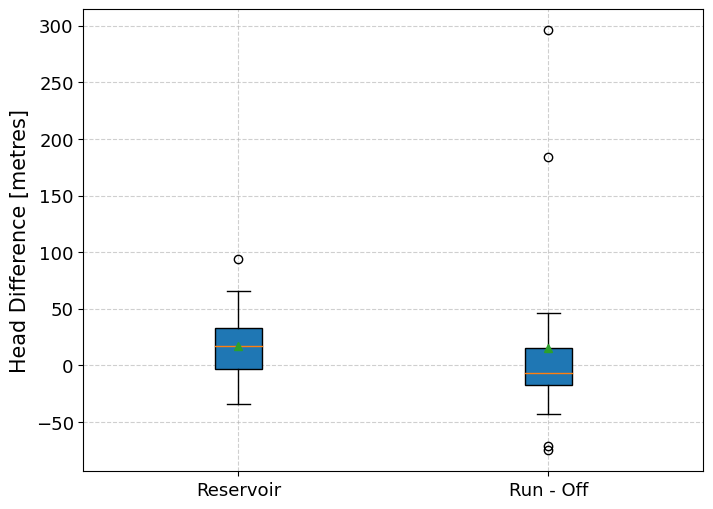

Missing head values have been filled and saved to 'updated_hydropower_plants_with_filled_heads.xlsx'.


In [205]:
import numpy as np
import pandas as pd
import rasterio
from shapely.geometry import Point
from pyproj import CRS, Proj
import geopandas as gpd
import matplotlib.pyplot as plt

# Coordinate Reference Systems
wgs84 = CRS("EPSG:4326")
merc = CRS("EPSG:3395")
merc_pro = Proj("EPSG:3395")

class LocalHydroNetwork:
    def __init__(self, dem_path, flow_path, flow_acc_path):
        self.dem = rasterio.open(dem_path)
        self.flow = rasterio.open(flow_path)
        self.flow_acc = rasterio.open(flow_acc_path)

    def create_local_network(self, point, buffer=0.005):
        minx, miny = point.x - buffer, point.y - buffer
        maxx, maxy = point.x + buffer, point.y + buffer

        window = rasterio.windows.from_bounds(minx, miny, maxx, maxy, self.dem.transform)
        dem_local = self.dem.read(1, window=window)
        flow_local = self.flow.read(1, window=window)
        flow_acc_local = self.flow_acc.read(1, window=window)

        transform = rasterio.windows.transform(window, self.dem.transform)

        nodes, arcs = self._extract_nodes_arcs(dem_local, flow_local, flow_acc_local, transform)
        return nodes, arcs

    def _extract_nodes_arcs(self, dem_local, flow_local, flow_acc_local, transform):
        nodes = []
        arcs = []
        height, width = dem_local.shape
        node_index_map = {}

        for i in range(height):
            for j in range(width):
                x, y = transform * (j, i)
                elevation = dem_local[i, j]
                flow_dir = flow_local[i, j]
                flow_acc = flow_acc_local[i, j]

                current_node = (i, j)
                if current_node not in node_index_map:
                    node_id = len(nodes)
                    node = {
                        'id': node_id,
                        'x': x,
                        'y': y,
                        'elevation': elevation,
                        'flow_acc': flow_acc,
                        'arcs': []
                    }
                    nodes.append(node)
                    node_index_map[current_node] = node_id
                else:
                    node_id = node_index_map[current_node]

                if flow_dir > 0:
                    next_i, next_j = self._flow_direction_to_indices(i, j, flow_dir)
                    if 0 <= next_i < height and 0 <= next_j < width:
                        next_node = (next_i, next_j)
                        if next_node not in node_index_map:
                            next_node_id = len(nodes)
                            next_x, next_y = transform * (next_j, next_i)
                            next_elevation = dem_local[next_i, next_j]
                            next_flow_acc = flow_acc_local[next_i, next_j]

                            next_node_data = {
                                'id': next_node_id,
                                'x': next_x,
                                'y': next_y,
                                'elevation': next_elevation,
                                'flow_acc': next_flow_acc,
                                'arcs': []
                            }
                            nodes.append(next_node_data)
                            node_index_map[next_node] = next_node_id
                        else:
                            next_node_id = node_index_map[next_node]

                        arc = {
                            'start_node': node_id,
                            'end_node': next_node_id,
                            'length': np.hypot(next_i - i, next_j - j)
                        }
                        nodes[node_id]['arcs'].append(arc)
                        arcs.append(arc)

        return nodes, arcs

    def _flow_direction_to_indices(self, i, j, direction):
        if direction == 1:  # East
            return i, j + 1
        elif direction == 2:  # Southeast
            return i + 1, j + 1
        elif direction == 4:  # South
            return i + 1, j
        elif direction == 8:  # Southwest
            return i + 1, j - 1
        elif direction == 16:  # West
            return i, j - 1
        elif direction == 32:  # Northwest
            return i - 1, j - 1
        elif direction == 64:  # North
            return i - 1, j
        elif direction == 128:  # Northeast
            return i - 1, j + 1
        else:
            return i, j  # No direction

    def calculate_head(self, nodes, arcs):
        max_head = 0
        for arc in arcs:
            start_node = nodes[arc['start_node']]
            end_node = nodes[arc['end_node']]
            head = start_node['elevation'] - end_node['elevation']
            if head > max_head:
                max_head = head
        return max_head

    def process_hydropower_plants(self, df, buffer):
        df['head_calculated'] = pd.NA
        for index, row in df.iterrows():
            point = Point(row['Longitude'], row['Latitude'])
            nodes, arcs = self.create_local_network(point, buffer)
            head = self.calculate_head(nodes, arcs)
            df.at[index, 'head_calculated'] = head
        df['head_difference'] = df['head'] - df['head_calculated']
        return df

    def optimize_buffer(self, df, buffer_range):
        best_mae = float('inf')
        best_std = float('inf')
        best_buffer = None
        best_df = None
        
        for buffer in buffer_range:
            df_processed = self.process_hydropower_plants(df.copy(), buffer)
            mae = df_processed['head_difference'].abs().mean()
            std = df_processed['head_difference'].std()
            if mae + std < best_mae + best_std:
                best_mae = mae
                best_std = std
                best_buffer = buffer
                best_df = df_processed
        
        print(f"Optimal Buffer: {best_buffer}")
        print(f"Mean Absolute Error: {best_mae}")
        print(f"Standard Deviation: {best_std}")
        
        return best_df, best_buffer, best_mae, best_std

    def optimize_for_fuel_types(self, df, buffer_range):
        # Optimize only for rows with existing head values
        reservoir_df = df[df['Fuel Type'] == 'Reservoir'].dropna(subset=['head']).copy()
        runoff_df = df[df['Fuel Type'] == 'Run - Off'].dropna(subset=['head']).copy()

        print("\nOptimizing for Reservoir plants...")
        optimized_reservoir_df, optimal_reservoir_buffer, reservoir_mae, reservoir_std = self.optimize_buffer(reservoir_df, buffer_range)
        
        print("\nOptimizing for Run - Off plants...")
        optimized_runoff_df, optimal_runoff_buffer, runoff_mae, runoff_std = self.optimize_buffer(runoff_df, buffer_range)

        return {
            'reservoir': {
                'df': optimized_reservoir_df, 
                'buffer': optimal_reservoir_buffer, 
                'mae': reservoir_mae, 
                'std': reservoir_std
            },
            'runoff': {
                'df': optimized_runoff_df, 
                'buffer': optimal_runoff_buffer, 
                'mae': runoff_mae, 
                'std': runoff_std
            }
        }

    def calculate_and_fill_missing_heads(self, df, reservoir_buffer, runoff_buffer):
        # Process all rows with the optimized buffer sizes
        df_reservoir = self.process_hydropower_plants(df[df['Fuel Type'] == 'Reservoir'].copy(), reservoir_buffer)
        df_runoff = self.process_hydropower_plants(df[df['Fuel Type'] == 'Run - Off'].copy(), runoff_buffer)

        # Combine results back into the original DataFrame
        df_combined = pd.concat([df_reservoir, df_runoff])

        # Fill missing head values in the original DataFrame
        for index, row in df_combined.iterrows():
            if pd.isna(df.at[index, 'head']):
                df.at[index, 'head'] = df_combined.at[index, 'head_calculated']

        return df

# Example usage
buffer_range = np.linspace(0.00025, 0.005, 101)
hydro_network = LocalHydroNetwork(dem_path, flow_path, flow_acc_path)

# Load your hydropower plant data
df = pd.read_excel(xlsx_file)

# Optimize buffer separately for Reservoir and Run-Off using only rows with existing head values
results = hydro_network.optimize_for_fuel_types(df, buffer_range)


# Now use the optimal buffer size to calculate and fill missing head values for all rows
filled_df = hydro_network.calculate_and_fill_missing_heads(df, results['reservoir']['buffer'], results['runoff']['buffer'])

# Save the updated DataFrame to a new Excel file
filled_df.to_excel("updated_hydropower_plants_with_filled_heads.xlsx", index=False)

print("Missing head values have been filled and saved to 'updated_hydropower_plants_with_filled_heads.xlsx'.")
